In [82]:
from fastai.collab import *
from fastai.tabular import *
import numpy as np
import matplotlib.pylab as plt
from scipy import stats

In [60]:
def get_data(path, standard_type = 'KD', transformation = None):
    df_all = pd.read_csv(path)
    df_filtered = df_all[df_all.standard_value!=0].copy()
    df_filtered = df_filtered[(df_all.standard_type==standard_type) & 
                  (df_all.standard_relation=='=')][['compound_id', 'target_id', 
                                                    'standard_value', 'standard_units']].dropna().copy()
    df_filtered = df_filtered[~df_filtered.target_id.str.contains(',')]
    if transformation == None:
        target_name = standard_type
        df_filtered[target_nanme] = df_filtered['standard_value']
    else:
        target_name = standard_type + transformation.__name__
        df_filtered[target_name] = transformation(df_filtered['standard_value'])
    
    return df_filtered, target_name

In [61]:
path = Path('/home/jupyter/.fastai/data/kinase/DTC_data.csv')

In [32]:
columns = df_DTC.columns; columns

Index(['compound_id', 'standard_inchi_key', 'compound_name', 'synonym',
       'target_id', 'target_pref_name', 'gene_names', 'wildtype_or_mutant',
       'mutation_info', 'pubmed_id', 'standard_type', 'standard_relation',
       'standard_value', 'standard_units', 'activity_comment',
       'ep_action_mode', 'assay_format', 'assaytype', 'assay_subtype',
       'inhibitor_type', 'detection_tech', 'assay_cell_line',
       'compound_concentration_value', 'compound_concentration_value_unit',
       'substrate_type', 'substrate_relation', 'substrate_value',
       'substrate_units', 'assay_description', 'title', 'journal', 'doc_type',
       'annotation_comments'],
      dtype='object')

In [62]:
df_Kd, target_name = get_data(path, standard_type='KD', transformation=np.log)

/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3185: DtypeWarning: Columns (0,1,2,3,8,14,21,22,23,24,25,26,27,30,32) have mixed types. Specify dtype option on import or set low_memory=False.
  if (yield from self.run_code(code, result)):
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """


In [44]:
df_Kd.head()

,compound_id,target_id,standard_value,standard_units,KDlog
216,CHEMBL135581,P00374,0.5,NM,-0.693147
217,CHEMBL135581,P00374,0.6,NM,-0.510826
218,CHEMBL135581,P00374,450.0,NM,6.109248
219,CHEMBL135581,P00374,1000.0,NM,6.907755
220,CHEMBL135581,P00374,1200.0,NM,7.090077


In [63]:
df_Kd.shape

(32625, 5)

In [64]:
df_Kd.KDlog.describe()

count    32625.000000
mean         5.364442
std          3.458598
min        -18.420681
25%          2.995732
50%          5.669881
75%          7.649693
max         25.328436
Name: KDlog, dtype: float64

In [65]:
Kd_data = CollabDataBunch.from_df(df_Kd, user_name='compound_id',
                                         item_name='target_id',
                                         rating_name=target_name, seed=40)

In [66]:
Kd_data.show_batch()

compound_id,target_id,target
CHEMBL103667,P00519,9.047821044921875
CHEMBL1789941,O75582,4.9416422843933105
CHEMBL379218,Q8N4C8,4.605170249938965
CHEMBL475251,P36888,-0.9942522644996643
CHEMBL538053,Q01959,8.160518646240234


In [67]:
Kd_learn = collab_learner(Kd_data, n_factors=50, 
                          y_range=[-20, 30])

In [68]:
Kd_learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


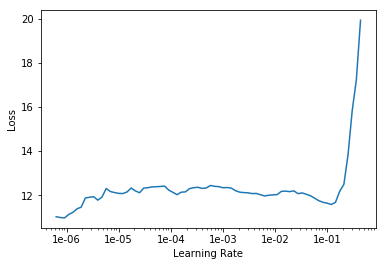

In [69]:
Kd_learn.recorder.plot()

In [70]:
Kd_learn.fit_one_cycle(10, 1e-2)

epoch,train_loss,valid_loss
1,8.542627,7.186950
2,5.463815,6.161644
3,4.976466,7.235197
4,5.215960,7.170148
5,4.761083,6.569350
6,3.664170,5.937446
7,2.369787,5.360153
8,1.750033,5.155908
9,0.880052,5.037480
10,0.551732,5.036751


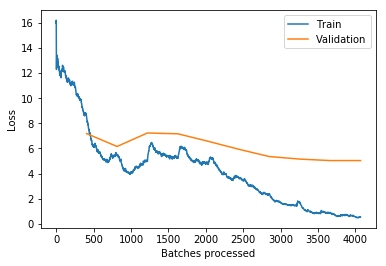

In [71]:
Kd_learn.recorder.plot_losses()

In [107]:
Kd_learn.fit_one_cycle(10, 1e-2)

epoch,train_loss,valid_loss
1,0.762710,5.193181
2,2.321463,6.254951
3,4.517321,7.511279
4,5.052692,7.245592
5,4.474113,6.765199
6,3.734958,6.042269
7,2.442249,5.529686
8,1.479950,5.222150
9,0.939413,5.137821
10,0.633723,5.134237


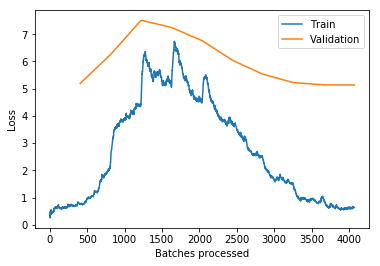

In [113]:
Kd_learn.recorder.plot_losses()

In [108]:
Kd_learn.show_results(rows=10)

compound_id,target_id,target,prediction
CHEMBL2024149,P0DMS8,-0.8278220891952515,3.8496265411376953
CHEMBL1544,P10827,-2.8473122119903564,-2.3591575622558594
#na#,P30968,0.0,0.36069488525390625
CHEMBL1721885,Q9Y4K4,5.703782558441162,5.620752334594727
CHEMBL522892,Q16513,9.200289726257324,9.163154602050781
CHEMBL3311525,O00214,12.506176948547363,13.29690933227539
#na#,P47811,0.6418538689613342,0.4641876220703125
CHEMBL535,Q86UE8,5.799092769622803,3.503143310546875
CHEMBL522892,O14757,7.090076923370361,6.97368049621582
#na#,P15056,4.465908050537109,5.462493896484375


In [109]:
Kd_preds = Kd_learn.get_preds()

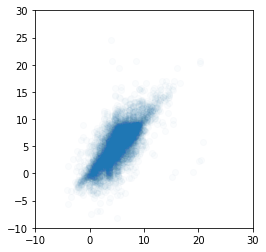

In [103]:
plt.scatter(Kd_preds[0], Kd_preds[1], alpha=0.02)
plt.xlim([-10, 30])
plt.ylim([-10, 30])
plt.gca().set_aspect('equal')

In [83]:
slope, intercept, r_value, p_value, std_err = stats.linregress(Kd_preds[0], Kd_preds[1])

In [84]:
r_value

0.7510411179033265

In [87]:
slope, intercept

(0.9259262306662102, 0.498946113307869)

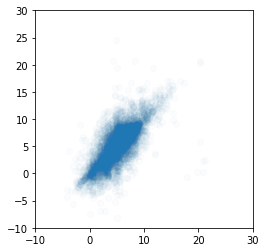

In [110]:
plt.scatter(Kd_preds[0], Kd_preds[1], alpha=0.02)
plt.xlim([-10, 30])
plt.ylim([-10, 30])
plt.gca().set_aspect('equal')

In [111]:
slope, intercept, r_value, p_value, std_err = stats.linregress(Kd_preds[0], Kd_preds[1])

In [112]:
r_value

0.7473625360965327

# todo
1. clean up
2. figure out #na# issue
3. clustering analysis

In [123]:
Kd_learn.data.valid_ds[20]

(CollabLine compound_id #na#; target_id P98170; , FloatItem 3.6888795)

In [128]:
df_Kd[(df_Kd.target_id=='P98170')&(df_Kd.KDlog>3.5)&(df_Kd.KDlog<4)]

,compound_id,target_id,standard_value,standard_units,KDlog
234223,CHEMBL184046,P98170,40.0,NM,3.688879
514972,CHEMBL360180,P98170,40.0,NM,3.688879
645175,CHEMBL310987,P98170,38.0,NM,3.637586
2305929,CHEMBL365676,P98170,50.0,NM,3.912023
2890787,CHEMBL2414998,P98170,40.0,NM,3.688879
3287092,CHEMBL183992,P98170,40.0,NM,3.688879
3460568,CHEMBL384327,P98170,38.0,NM,3.637586
3909769,CHEMBL187005,P98170,40.0,NM,3.688879
5417713,CHEMBL234346,P98170,40.0,NM,3.688879


# embedding NN (https://towardsdatascience.com/collaborative-filtering-with-fastai-3dbdd4ef4f00)

In [129]:
Kd_NN = collab_learner(Kd_data, use_nn=True, 
                       emb_szs={'compound_id': 40, 'target_id':40}, layers=[256, 128], y_range=(-20, 30))

In [130]:
Kd_NN.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


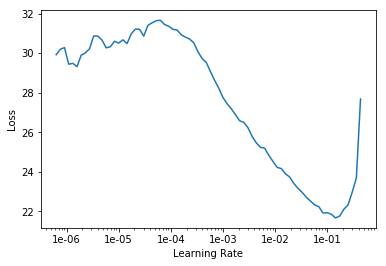

In [131]:
Kd_NN.recorder.plot()

In [132]:
Kd_NN.fit_one_cycle(10, 1e-2)

epoch,train_loss,valid_loss
1,7.964258,7.109387
2,7.033829,6.966299
3,5.202913,6.021425
4,4.209516,5.755021
5,3.284643,5.495564
6,2.724728,5.272191
7,1.991817,5.073779
8,1.722644,5.067656
9,1.482349,5.069295
10,1.415197,4.989756


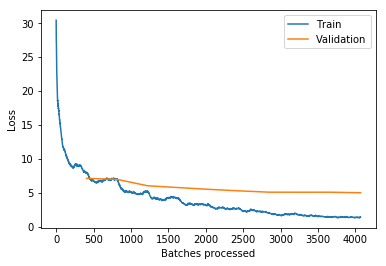

In [133]:
Kd_NN.recorder.plot_losses()

In [134]:
Kd_NN.show_results()

compound_id,target_id,target,prediction
CHEMBL2024149,P0DMS8,-0.8278220891952515,3.9437103271484375
CHEMBL1544,P10827,-2.8473122119903564,-2.0686683654785156
#na#,P30968,0.0,0.21334075927734375
CHEMBL1721885,Q9Y4K4,5.703782558441162,4.924684524536133
CHEMBL522892,Q16513,9.200289726257324,7.825107574462891


In [136]:
Kd_NN_preds = Kd_NN.get_preds()

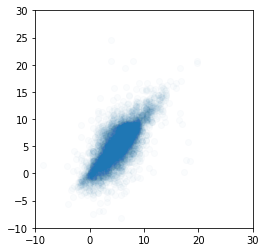

In [137]:
plt.scatter(Kd_NN_preds[0], Kd_NN_preds[1], alpha=0.02)
plt.xlim([-10, 30])
plt.ylim([-10, 30])
plt.gca().set_aspect('equal')

In [142]:
slope, intercept, r_value, p_value, std_err = stats.linregress(Kd_NN_preds[0].flatten(), Kd_NN_preds[1])

In [143]:
r_value

0.7533962542105362